In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# Parameter Estimation: Model Fitting

<!--- Outline

1. Parameter estimation problem 
    * estimator is a procedure
    * bias and variance;  B-V tradeoff (goodfellow p 120)
2. concept of model fitting
    * parameters and data ; notation and concepts (examples)
2. Maximum likelihood principle
    * likelihood is thinking of $p(x; \theta)$ as a function of $\theta$
    * Goodfellow p 128 for defns;  perhaps use some background from earlier pages
3. Simple examples
    * binomial.  solve in closed form
4. Log-likelihood and cross-entropy loss (goodfellow p 129 ff)
    * difference between the distribution of the data and the distribution of the model
    * did not cover this in the end -- should we?
5. Simple examples
    * poisson
6. Model fitting: least squares (godfellow p 130) (they will have seen least squares in DS 121)
    * this is important - introduce the "model for which the method is an MLE" idea
    * but may need to move to next lecture
    * did not cover this in the end
7. Properties of ML estimate (goodfellow p 131)
--->

```{margin}
This section draws from Chapter 5 of _Deep Learning_ by Goodfellow, Bengio, and Courville.
```

### Review Parameter Estimation: Estimators

We treat the data as an __independent and identically distributed__ (or __i.i.d.__) sample from some population distribution. 

<center>
    
<img src="images/population_sample.png" width="500px"/>
<!-- source: https://www.omniconvert.com/what-is/sample-size/ -->   
  
</center>

__Parameter estimation__ is inference about an unknown population parameter (or set of population parameters) based on a sample statistic.

A __statistic__ is anything (i.e., any function) that can be computed from the collected data sample. A statistic must be observable. 

Informally speaking, a __function__ from set $A$ to set $B$ is an instruction that couples _each_ element of $A$ with _exactly one_ element of $B$. It can be expressed as a formula ($f(x) = x^2$ or $g(s) = a+bs$ are two examples of functions expressed with a formula), graph (e.g., a graph of a linear function is a straight line), or even as a table (grades of students who took an exam). 

In the Bernoulli example from the last lecture, the function we used for the estimator of the population mean was the sample mean. But we also looked at an example where the estimator was just a constant function.

A __point estimator__ is a statistic that is used to estimate the unknown population parameter. The realisation of a point estimator is a single point. A point estimator is a __random variable__ which has a probability distribution referred to as its __sampling distribution__.

<center>
    
<img src="images/sampling_distribution.png"/>
   
</center>

<!-- based on https://creativemaths.net/blog/sampling-distribution/ -->

Evaluation of the estimator:
- Bias: it measures the expected deviation from the true value of the parameter. A good estimator has low bias.
- Variance: it measures how much the estimator can vary as a function of the data sample. A good estimator has low variance.
- Mean Squared Error: It measures the "average distance squared" between the estimator and the true value. It incorporates both the bias and the variance.

<center>
    
<img src="images/RMS.png"/>
   
    
    
</center>

<!-- from previous lecture -->

__Extra Question__. Suppose $\{x^{(1)},x^{(2)}, \dots, x^{(n)}\}$ is an i.i.d. sample from the exponential distribution with rate $\lambda$. Consider the following estimator for $\theta = \frac{1}{\lambda}$:

$$\hat{\theta} = \frac{1}{n+1}\sum_{i=1}^n x^{(i)}.$$

a. Find the bias of $\hat{\theta}$.<br> 
__Answer__. $\operatorname{bias}\left(\hat{\theta}\right)=\frac{-\theta}{n+1}.$ <br> 
b. Find the variance of $\hat{\theta}$.<br>
__Answer__. $\operatorname{Var}\left(\hat{\theta}\right) = \frac{n}{n+1} \theta^2.$<br> 
c. Find the mean squared error of $\hat{\theta}$.<br>
__Answer__. $\operatorname{MSE}\left(\hat{\theta}\right) = \frac{\theta^2}{n+1}.$<br> 

## Model Fitting

The notion of parameter estimation is closely related to the concept called model fitting. We have actually been doing this quite a bit already, but now we want to treat the notion more directly.

Imagine that you know that data is drawn from a particular __kind__ of distribution, but you don't know the value(s) of the distribution's parameter(s). 

The following table shows a number of common distributions and their corresponding parameters:


| Distribution | Parameters $\theta$ |
| --- | --- | 
|Bernoulli   | $p$ |
|Binomial    | $(N,p)$ |
|Poisson     | $\lambda$ |
|Geometric   | $p$ |
|Exponential | $\lambda$ |
|Uniform     | $(a,b)$ |
|Normal      | $(\mu, \sigma)$ |

We formalize the problem as follows.  We say that data is drawn from a distribution

$$ p(x; \theta). $$

The way to read this is: the probability of $x$ under a distribution having parameter(s) $\theta$.

We call $p(x; \theta)$ a __family__ of distributions because there is a different distribution for each value of $\theta$. 

The graph below illustrates the probability density functions of several normal distributions (from the same parametric family).

<center>
    
<img src="images/Probability_distribution_functions_for_normal_distribution.svg" width="500px"> 
  
</center>

<!-- By Dmottl - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=53241138 -->  

__Model fitting__ is finding the parameters $\theta$ of the distribution given that we know some data $x$.

Notice that in this context, it is the parameters $\theta$ that are varying (not the data $x$).

When we think of $p(x; \theta)$ as a function of $\theta$ (instead of $x$, say) we call it a __likelihood__.

This change in terminology is just to emphasize that we are thinking about varying $\theta$ when we look at the probability $p(x; \theta)$.

For example, consider the dataset below:

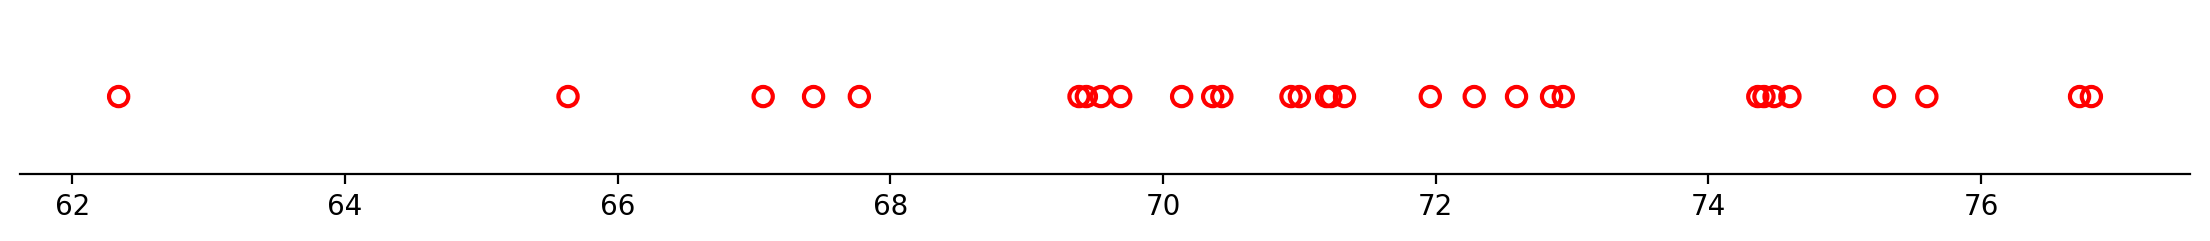

In [3]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# specify the parameters
mu = 70 
sig = 3
#
samp_size = 30
rng = 0

fig, ax = plt.subplots(1, 1, figsize = (14,1))

# sample
samp_x = norm.rvs(size = samp_size, loc = mu, scale = sig, random_state = rng)
samp_y = [1 for x in samp_x]
ax.scatter(samp_x, samp_y, marker = 'o', facecolors='none', edgecolors='red', linewidths = 1.5, s = 48)
#ax.set_xlim(xmin, xmax)
#ax.set_title('height [inches]')
ax.yaxis.set_visible(False)
# remove the "box" around the plot
for spine in [list(ax.spines.values())[i] for i in [0, 1, 3]]:
    spine.set_visible(False)

Can you imagine that this dataset might be drawn from a Normal distribution?

In that case, 

$$ p(x; \theta) = \mathcal{N}(x; \mu, \sigma^2). $$

Then model fitting would consist of finding the $\mu$ and $\sigma$ that best match the given data $x$ shown above.

In other words, the likelihood function gives the probability of observing the given data as a function of the parameter(s). Therefore, the parameters can be estimated by maximizing the likelihood function. We will do that in the next lecture. In this lecture we focus on computing the likelihood function.

## Calculating Likelihood

Let's think about how to calculate likelihood. Consider a set of $m$ data items 

$$ X = \{x^{(1)}, \dots, x^{(m)}\} $$ 

drawn independently from the true but unknown data-generating distribution $p_{\text{data}}(x)$.

Let $p_{\text{model}}(x; \theta)$ be a family of probability distributions over the same space.   

Then, for any value of $\theta$, $p_{\text{model}}(x; \theta)$ maps a particular data item $x$ to a real number that we can use as an estimate of the true probability $p_{\text{data}}(x)$.

What is the probability of the entire dataset $X$ under the model?

We assume that the $x^{(i)}$ are independent;  so the probabilities multiply.

Therefore, the joint probability is

$$ p_{\text{model}}(X; \theta) =  p_{\text{model}}(x^{(1)}; \theta) \cdot \ldots \cdot p_{\text{model}}(x^{(m)}; \theta). $$


We can use a special shorthand notation to represent products. Just like $\sum$ is shorthand for summing, $\prod$ is shortand for taking the product.

For example, the product of two numbers $a_1$ and $a_2$ (i.e., $a_1 a_2$), can be written as $\prod_{i=1}^2 a_i$.

So the joint probability can be written as:

$$ p_{\text{model}}(X; \theta) = \prod_{i=1}^m p_{\text{model}}(x^{(i)}; \theta). $$


Now, each individual $p_{\text{model}}(x^{(i)}; \theta)$ is a value between 0 and 1.

And there are $m$ of these numbers being multiplied.   So for any reasonable-sized dataset, the joint probability is going to be __very small__.

For example, if a typical probability is $1/10$, and there are 500 data items, then the joint probability will be a number on the order of $10^{-500}$.   

So the probability of a given dataset as a number will usually be too small to even represent in a computer using standard floating point!

## Log-Likelihood

Luckily, there is an excellent way to handle this problem. Instead of using likelihood, we will use the log of likelihood.  

The table below shows some of the properties of the natural logarithm.

|||
| --- | --- | 
|Product rule | $\log ab = \log a + \log b$ |
|Quotient rule | $\log \frac{a}{b} = \log a - \log b$ |
|Power rule   | $\log a^n = n \log a$ |
|Exponential\logarithmic | $\log e^x = e^{\log x} = x$ |

__Question__. How can we rewrite $\log 6 + \log 5 - \log 4 + 2\log 2$?

a. $\log\frac{6}{5}$ <br>
b. $\log 30$<br>
c. $\log 30 - 4\log2$

__Answer__. b

In the next lecture we will see that we are only interested in the maxima of the likelihood function. Since the log function does not change those points (the log is a monotonic function), using the log of the likelihood works for us.

<center>
    
<img src="images/natural_log_max.png" width="600px"> 
  
</center>

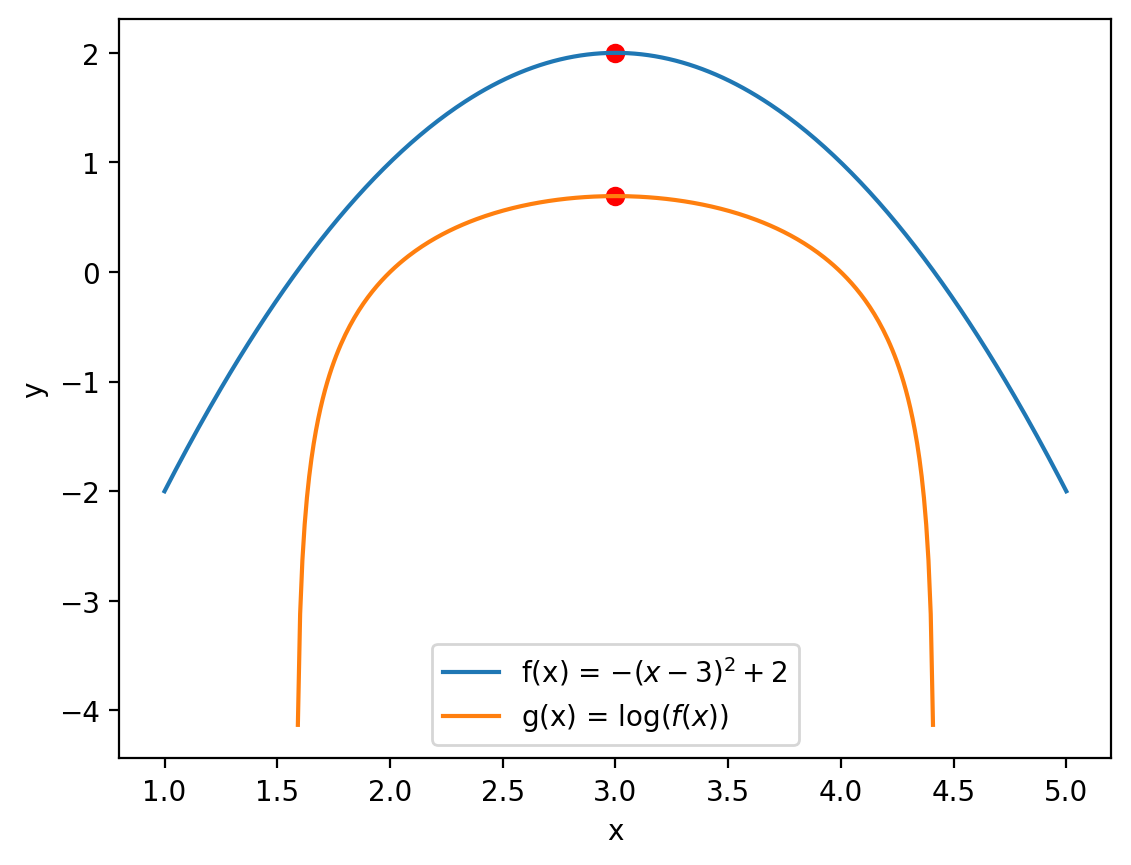

In [4]:
# Define the function -\left(x-3\right)^{2}+2
def f(x):
    return -(x - 3) ** 2 + 2

# Define the natural logarithm of the function
def g(x):
    return np.log(f(x))

# Generate x values from -1 to 7
x = np.linspace(1, 5, 400)

# Generate y values for the original function
y1 = f(x)

# Generate y values for the natural logarithm of the function
y2 = g(x)

# Find the maxima for both functions
f_max = np.max(y1)
g_max = np.log(2)

# Plot the original function
plt.plot(x, y1, label='f(x) = $-(x-3)^2+2$')
plt.scatter(3, f_max, color='red')

# Plot the natural logarithm of the function
plt.plot(x, y2, label='g(x) = $\\log(f(x))$')
plt.scatter(3, g_max, color='red')

# Set plot title and labels
plt.xlabel('x')
plt.ylabel('y')

# Add legend
plt.legend()

# Display the plot
plt.show()

So we will work with the log-likelihood:

$$  \log p_{\text{model}}(X; \theta). $$

Which becomes:

$$ \log p_{\text{model}}(X; \theta) = \log \prod_{i=1}^m p_{\text{model}}(x^{(i)}; \theta) = \sum_{i=1}^m \log p_{\text{model}}(x^{(i)}; \theta). $$

This way we are no longer multiplying many small numbers, and we work with values that are easy to represent.

__Question__. Which statement about $\log 0.05$ is correct?

a. $\log 0.05 \geq 0$<br>
b. $\log 0.05 < 0$<br>
c. $\log 0.05$ is not defined

__Answer__. b (In fact, $\log 0.05 \approx -3$.)

Note: The log of a number less than one is negative, so log-likelihoods are always negative values.

__Example__. 

Suppose that $x$ is a discrete random variable with the probability mass function shown below.

| $x$ | $0$ | $1$ | $2$ | $3$ |
| :---: | :---: | :---: | :---: | :---: |
| $p(x;\theta)$ | $\frac{2}{3}\theta$ | $\frac{1}{3}\theta$| $\frac{2}{3}\left(1-\theta\right)$| $\frac{1}{3}\left(1-\theta\right)$|

Here $0\leq \theta \leq 1$ is a parameter. The following 10 independent observations were taken from this distribution:

$$X = \{3,0,2,1,3,2,1,0,2,1\}.$$

We want to find the corresponding log-likelihood function.

Based on the observed data sample, the (joint) likelihood function is equal to

$$p(X;\theta) = \prod_{i=1}^{10}  p\left(x^{(i)}; \theta\right)=p(0;\theta)^2p(1;\theta)^3p(2;\theta)^3p(3;\theta)^2$$

$$=\left( \frac{2}{3}\theta \right)^2 \left( \frac{1}{3}\theta \right)^3 \left(\frac{2}{3}\left(1-\theta\right)\right)^3 \left(\frac{1}{3}\left(1-\theta\right)\right)^2.$$

Since the likelihood function is given by

$$ p(X;\theta) = \left( \frac{2}{3}\theta \right)^2 \left( \frac{1}{3}\theta \right)^3 \left(\frac{2}{3}\left(1-\theta\right)\right)^3 \left(\frac{1}{3}\left(1-\theta\right)\right)^2,$$

the log-likelihood function can be written as

$$\log p(X;\theta) = \log \left( \left( \frac{2}{3}\theta \right)^2 \left( \frac{1}{3}\theta \right)^3 \left(\frac{2}{3}\left(1-\theta\right)\right)^3 \left(\frac{1}{3}\left(1-\theta\right)\right)^2 \right) $$

$$ =2\left(\log\frac{2}{3}+ \log \theta \right) + 3\left(\log\frac{1}{3}+ \log \theta \right) + 3\left(\log\frac{2}{3}+ \log (1-\theta) \right) + 2\left(\log\frac{1}{3}+ \log (1-\theta) \right)$$

$$= 5\log \theta + 5\log (1-\theta) + 5\log\frac{2}{9}.$$

We can visualise the log-likelihood function by varying $\theta$.

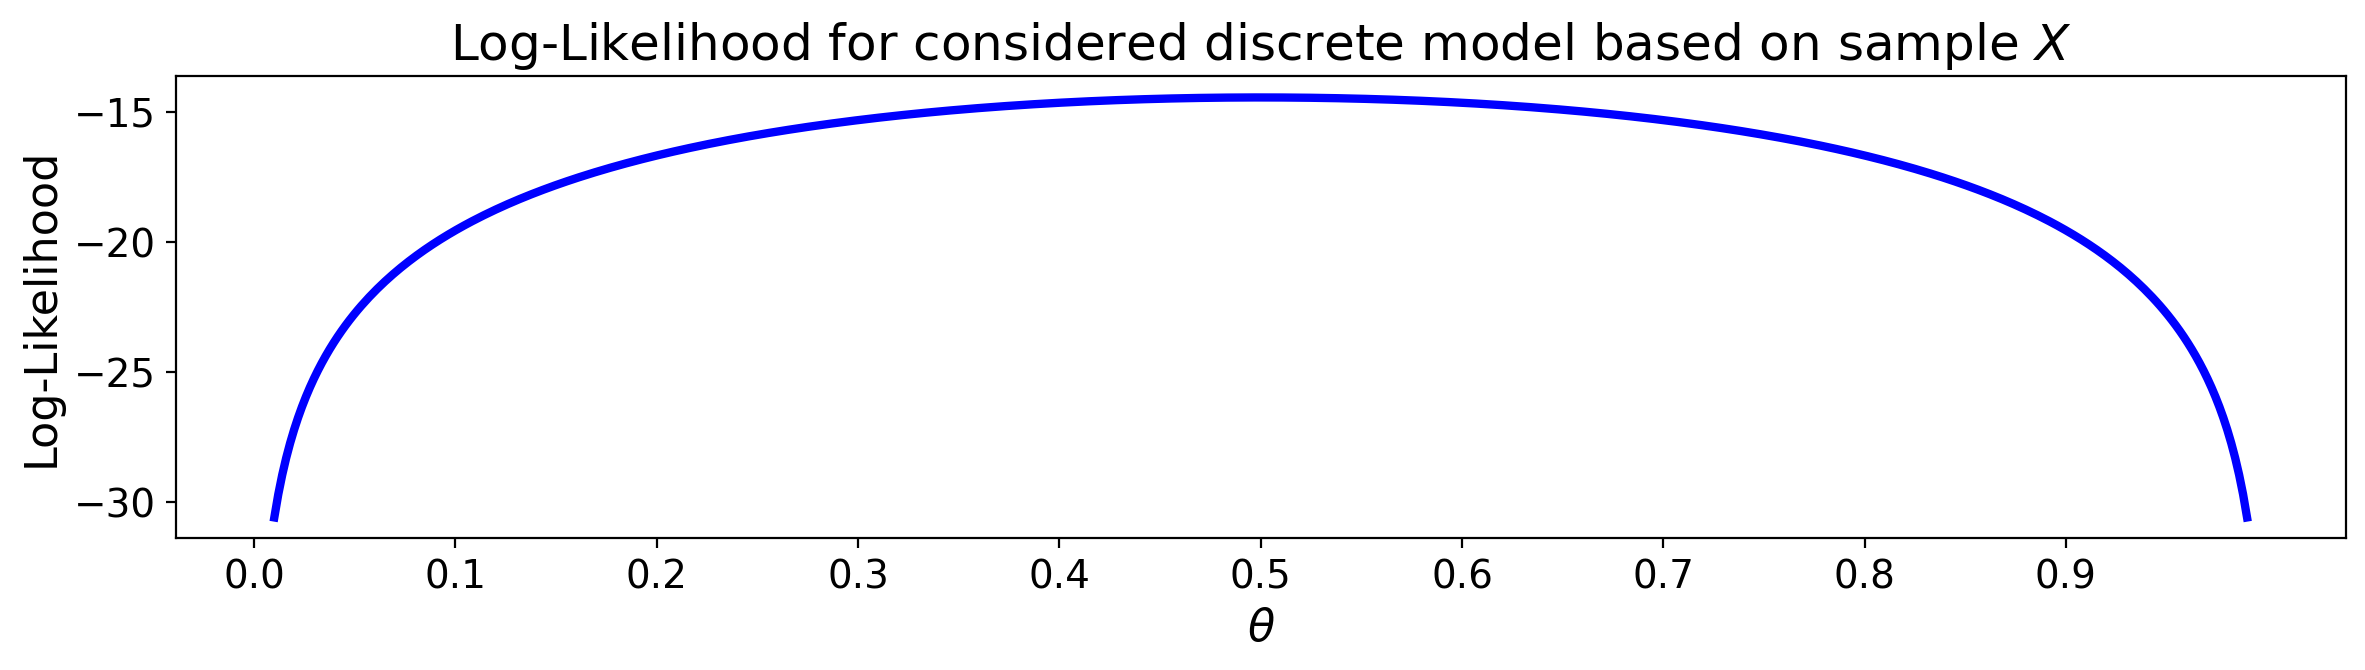

In [5]:
def loglik(theta):
    return 5*np.log(theta)+5*np.log(1-theta)+5*np.log(2/9)

fig = plt.figure(figsize = (14,3))
ax = plt.axes()

x = np.linspace(0.01, 0.99, 500)
ax.plot(x, loglik(x), lw = 3, color = 'blue')
ax.set_xlabel(r'$\theta$', size = 16)
ax.set_ylabel('Log-Likelihood', size = 16);
ax.set_xticks(np.arange(0, 1, 0.1))
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title(r'Log-Likelihood for considered discrete model based on sample $X$', size = 18);
plt.show()

__Question__. Suppose that $x$ is a discrete random variable with the probability mass function given by

| $x$ | $1$ | $2$ |
| :---: | :---: | :---: |
| $p(x;\theta)$ | $\theta$ | $1-\theta$|

Three independent oservations are made from this distribution:
$$x^{(1)} = 1, x^{(2)} = 2, x^{(3)} = 2. $$

What is the likelihood function?

a. $\log \theta + 2 \log(1-\theta)$<br>
b. $2\log \theta + \log(1-\theta)$<br>
c. $\theta (1-\theta)^2$<br>
d. $\theta (1-\theta)$

__Answer__. c

__Example.__

As an example, let's return to Bortkeiwicz's horse-kick data, and see how the log-likelihood changes for different values of the Poisson parameter $\lambda$. 

Recall that Bortkeiwicz had collected deaths by horse-kick in the Prussian army over a span of 200 years, and was curious whether they occurred at a constant, fixed rate. 

To do this he fitted the data to a Poisson distribution.   To do that, he needed to estimate the parameter $\lambda$.   

Let's see how the log-likelihood of the data varies as a function of $\lambda$.

In [7]:
# note that this data is available in 'data/HorseKicks.txt'
horse_kicks = pd.DataFrame(
data = np.array([
[0, 108.67, 109],
[1, 66.29, 65],
[2, 20.22, 22],
[3, 4.11, 3],
[4, 0.63, 1],
[5, 0.08, 0],
[6, 0.01, 0]]),
columns = ["Deaths Per Year","Predicted Instances (Poisson)","Observed Instances"])
horse_kicks["Deaths Per Year"] = horse_kicks["Deaths Per Year"].astype('int')
horse_kicks["Observed Instances"] = horse_kicks["Observed Instances"].astype('int')
horse_kicks[["Deaths Per Year","Observed Instances"]].style.hide(axis='index')

Deaths Per Year,Observed Instances
0,109
1,65
2,22
3,3
4,1
5,0
6,0


As a reminder, $\lambda$ is rate of deaths per year, and $T = 1$ reflects that we are interested in one-year intervals.

The Poisson distribution predicts:

$$ P[k \mbox{ deaths in time } T] = (\lambda T)^k \frac{e^{- \lambda T}}{k!}$$

Since $T = 1$ we can drop it, and so the likelihood of a particular number of deaths $x^{(i)}$ in year $i$ is:

$$ p(x^{(i)}; \lambda) = \lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}$$

The likelihood function then becomes

$$p(X;\lambda) = \prod_{i=1}^{m} \lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}.$$

The corresponding log-likelihood function can be written as 

$$ \log p(X; \lambda) =  \log \left(\prod_{i=1}^{m} \lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}\right) = \sum_{i=0}^m \log \left(\lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}\right). $$

Note that the log-likelihood of a particular number of deaths $x^{(i)}$ in year $i$ is equal to

$$ \log p(x^{(i)}; \lambda) = \log \left(\lambda^{x^{(i)}} \frac{e^{- \lambda}}{x^{(i)}!}\right) = x^{(i)} \log \lambda - \lambda - \log x^{(i)}! $$

Using this we can express the log-likelihood of the data as
    
$$ \log p(X; \lambda) = \sum_{i=0}^m \left( x^{(i)} \log \lambda - \lambda - \log x^{(i)}!\right) $$

Which looks like this as we vary $\lambda$:

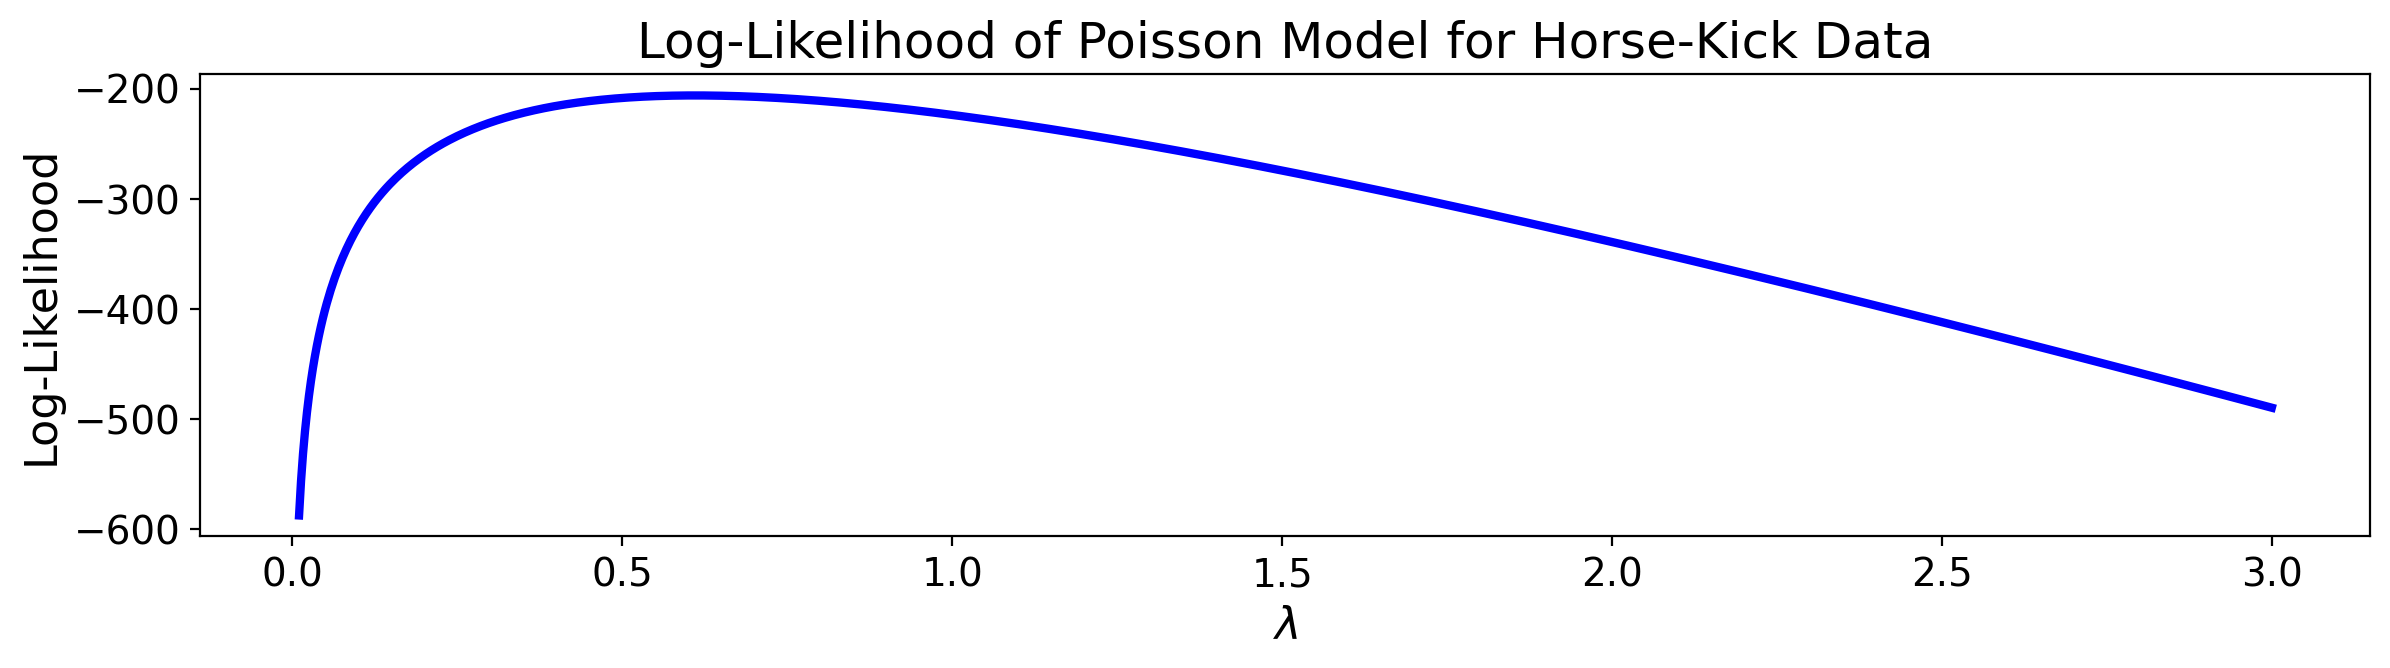

In [8]:
from scipy.stats import poisson

# assumes data is a list of counts for various values starting at zero
def ll(data, lam):
    return np.sum(data * poisson.logpmf(range(len(data)), lam))

xvals = np.linspace(0.01, 3, 1000)
ll_vals = [ll(horse_kicks['Observed Instances'], xval) for xval in xvals]

fig, ax = plt.subplots(1, 1, figsize = (14,3))
plt.plot(xvals, ll_vals, lw = 3, color = 'blue')
plt.ylabel('Log-Likelihood', size = 16)
plt.xlabel(r'$\lambda$', size = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title('Log-Likelihood of Poisson Model for Horse-Kick Data', size = 18);

Recall that for an arbitrary Normal distribution with mean $\mu$ and variance
$\sigma^2$, the PDF is given by

$$ p_{\mu,\sigma}(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}. $$

<center>

<img src="images/Galton-Bean-Machine.png" width="350px">
       
</center>

<center>
    Francis Galton's "Bean Machine"
</center>

__Example__.

Suppose $X =\{x^{(1)}, \dots, x^{(m)}\}$ represents the observed data from a normal distribution $N(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are the unknown parameters. To fit the data to a normal distribution we need to estimate both $\mu$ and $\sigma$.

The likelihood function is the product of the marginal densities:

$$p\left(X; \mu, \sigma \right) = p\left(x^{(1)}, \dots, x^{(m)}; \mu, \sigma \right)= \prod_{i=1}^{m}\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x^{(i)} - \mu}{\sigma} \right)^2}.$$

This can be rewritten as

$$p\left(X; \mu, \sigma\right)= \left(\frac{1}{\sigma \sqrt{2\pi}}\right)^m \exp\left(\sum_{i=1}^m -\frac{1}{2}\left(\frac{x^{(i)} - \mu}{\sigma} \right)^2 \right).$$

Since the likelihood function is equal to

$$p\left(X; \mu, \sigma \right)= \left(\frac{1}{\sigma \sqrt{2\pi}}\right)^m \exp\left(\sum_{i=1}^m -\frac{1}{2}\left(\frac{x^{(i)} - \mu}{\sigma} \right)^2 \right),$$

the log likelihood becomes

$$ \log p\left(X; \mu, \sigma \right) = \log \left(\sigma \sqrt{2\pi}\right)^{-m} + \sum_{i=1}^m \left(-\frac{1}{2}\right)\left(\frac{x^{(i)} - \mu}{\sigma} \right)^2 $$

$$=  -m\log \sigma - \frac{m}{2}\log(2\pi) -\frac{1}{2\sigma^2}\sum_{i=1}^m \left(x^{(i)} - \mu \right)^2.$$

### Python example
We consider a sample of size 100 from a normal distribution. Our goal is to visualize the corresponding log-likelihood function. To do so, first we create the log-likelihood function.

In [9]:
from scipy.stats import norm
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# create data sample
# population parameters
mu = 4
sigma = 1

# sample size
samp_size = 100

rng = 0
data = norm.rvs(size = samp_size, loc = mu, scale = sigma, random_state = rng)

In [10]:
# log-likelihood function for a normal distribution
# input: sample, parameters' domains
def normloglik(X,muV,sigmaV):
    m = len(X)
    return -m/2*np.log(2*np.pi) - m*np.log(sigmaV)\
    - (np.sum(np.square(X))- 2*muV*np.sum(X)+m*muV**2)/(2*sigmaV**2)

Note: The log-likelihood function of the normal distribution can also be written as

$$\log p\left(X; \mu, \sigma \right) =  - \frac{m}{2}\log(2\pi) -m\log \sigma -\frac{1}{2\sigma^2}\left( \sum_{i=1}^m \left(x^{(i)}\right)^2 - 2\mu \sum_{i=1}^m x^{(i)} + m\mu^2  \right).$$

If neither of the parameters is known, we can use a surface plot to visualize the log-likelihood as a function of both parameters.

In [11]:
# select parameters' domains
vec_mu    = np.arange(3, 5, 0.01)
vec_sigma = np.arange(0.5, 3, 0.01)

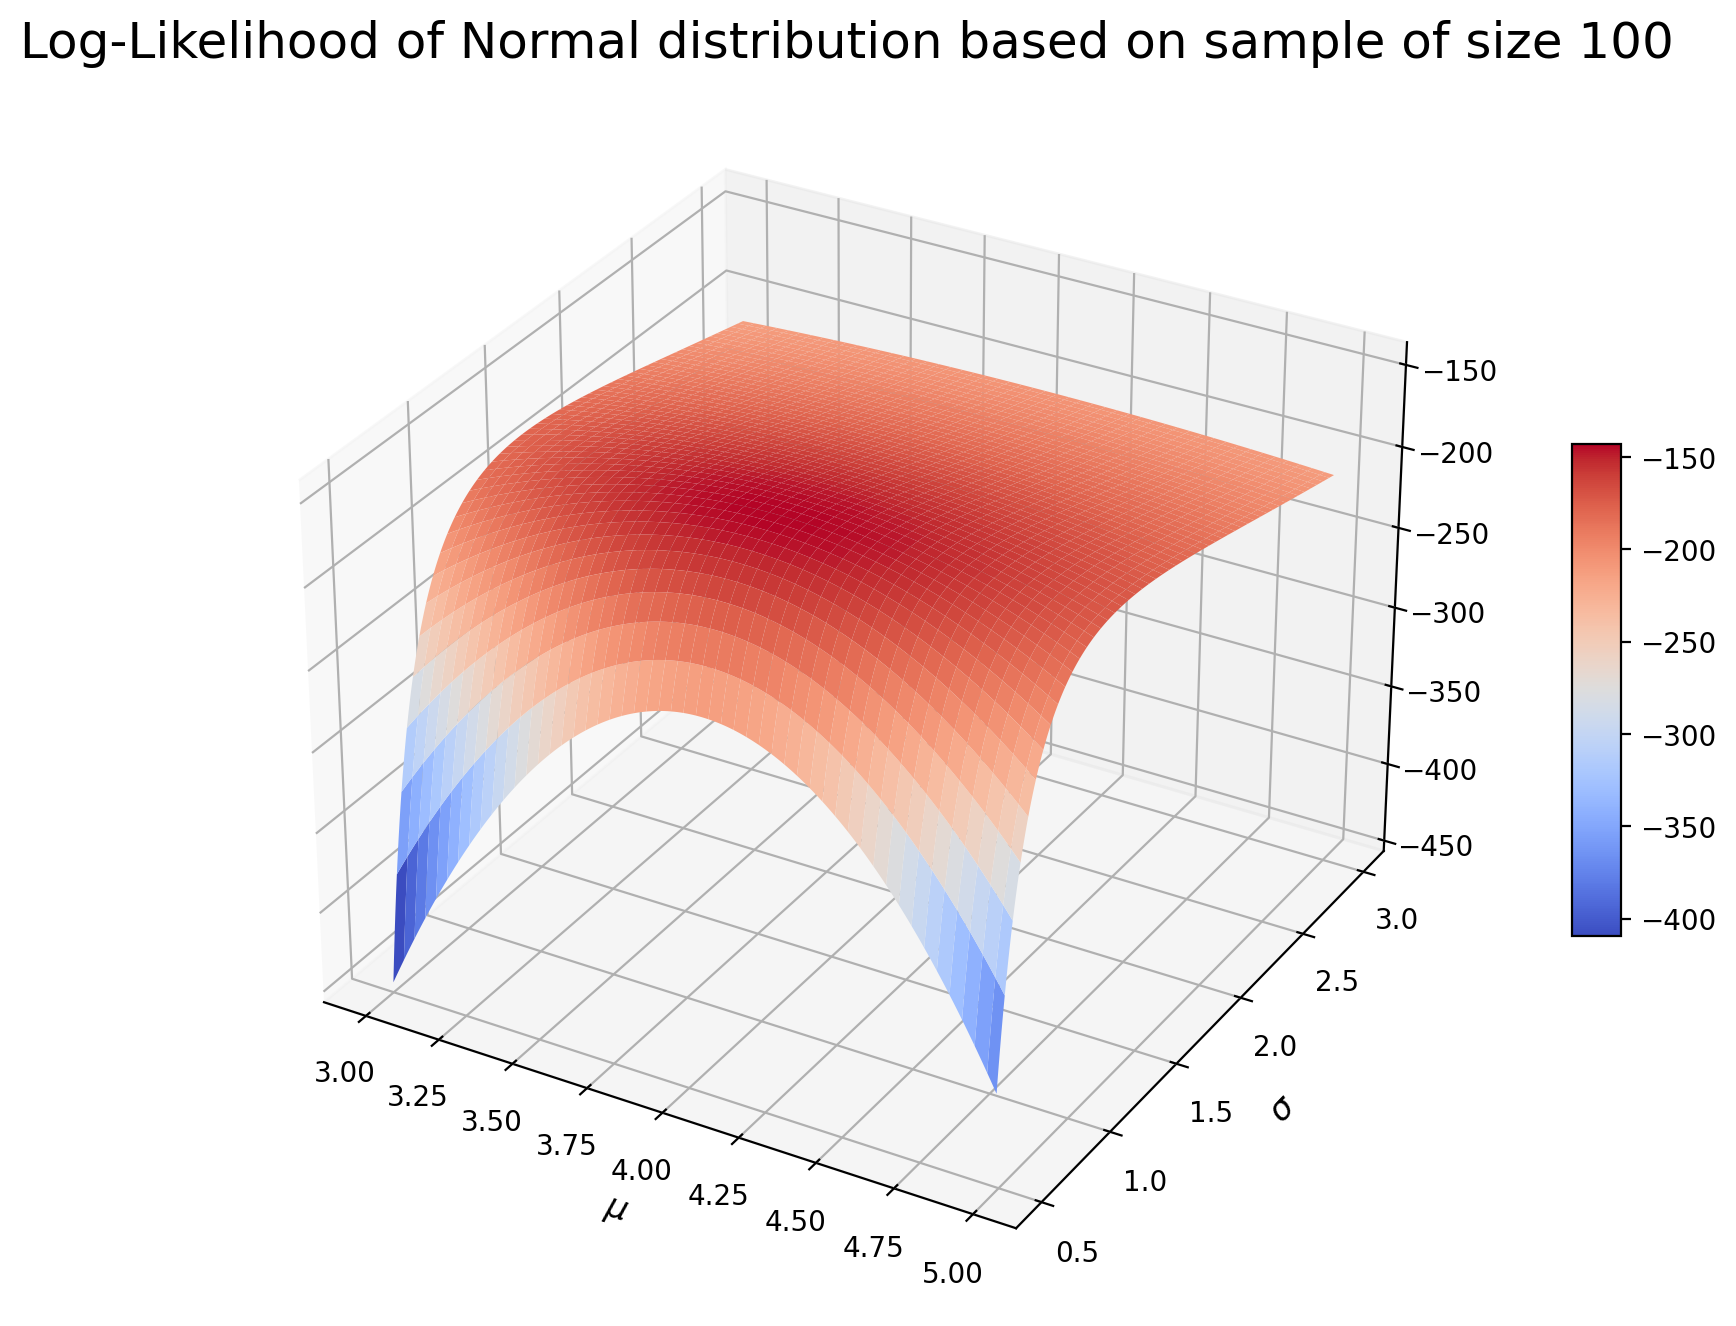

In [12]:
# make a surface plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 8))

x,y = np.meshgrid(vec_mu, vec_sigma)
z = normloglik(data,x,y)

# plot the surface
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,  linewidth=0)
ax.set_xlabel('$\mu$',size=12)
ax.set_ylabel('$\sigma$',size=12)

# add a color bar
fig.colorbar(surf, shrink=0.4, aspect=10)

plt.title('Log-Likelihood of Normal distribution based on sample of size 100', size = 18);
plt.show()

Alternatively, if one of the parameters is known, we visualize the log-likelihood as function of the unknown parameter.

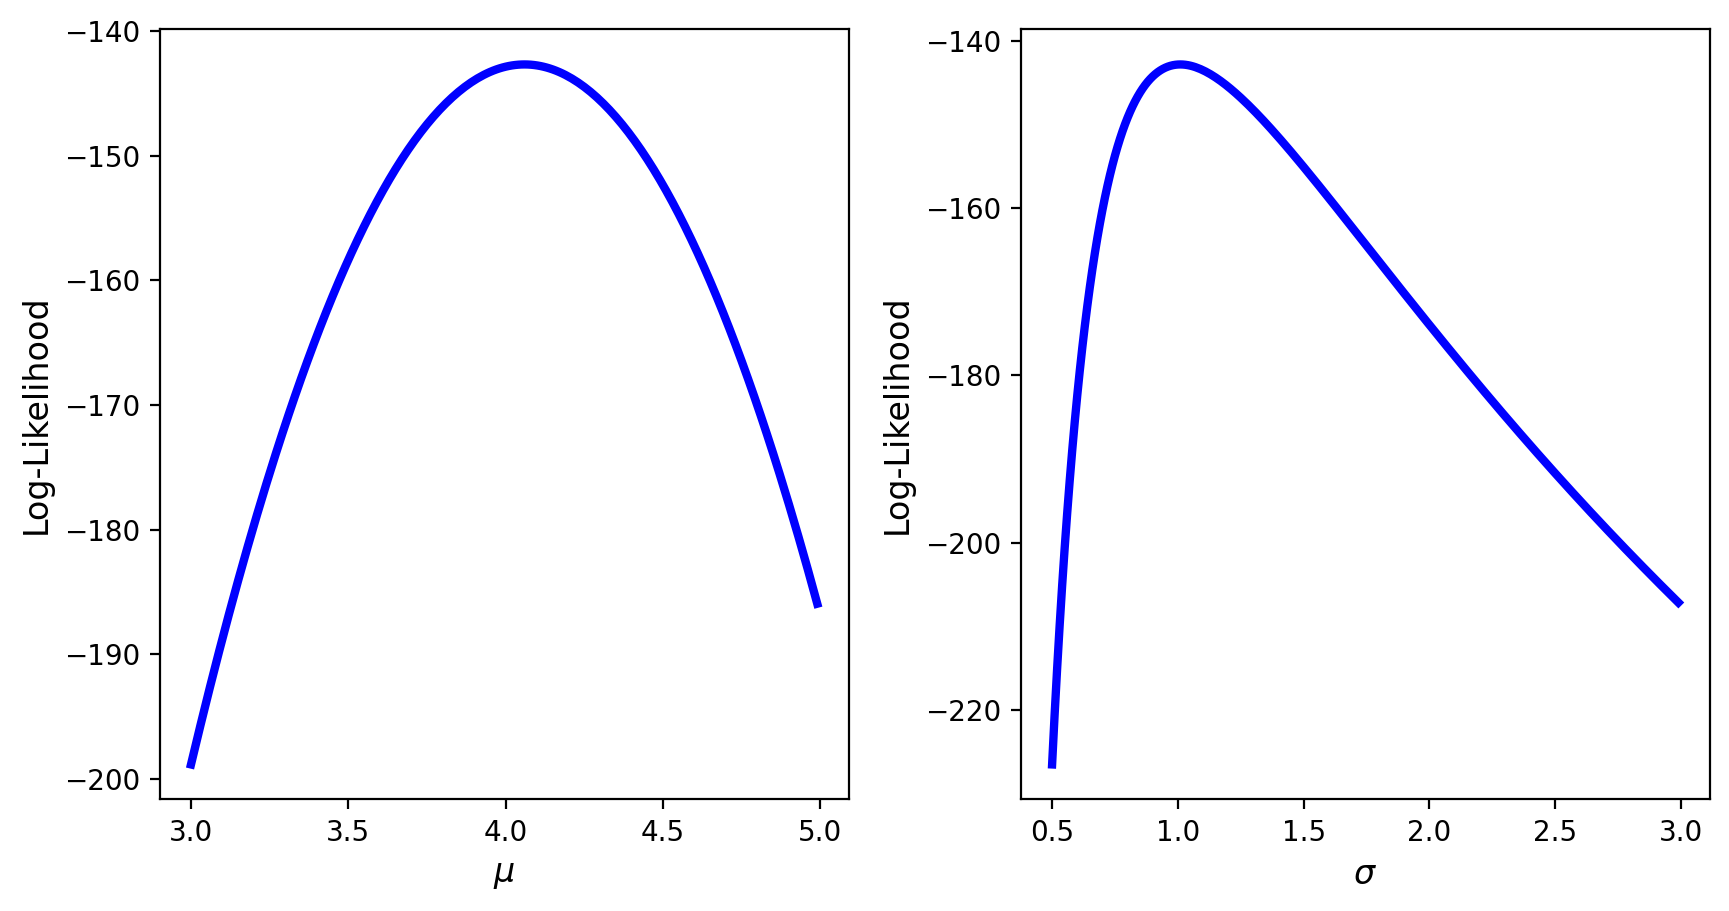

In [13]:
# make line plots
f, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False)
plt.subplots_adjust(wspace=.25,hspace=0)
axs[0].plot(vec_mu, normloglik(data,vec_mu,sigma), lw = 3, color = 'blue')
axs[0].set_xlabel('$\mu$',size=12)
axs[0].set_ylabel('Log-Likelihood',size=12)

axs[1].plot(vec_sigma, normloglik(data,mu,vec_sigma), lw = 3, color = 'blue')
axs[1].set_xlabel('$\sigma$',size=12)
axs[1].set_ylabel('Log-Likelihood',size=12)

plt.show()

### Summary
1. The notion of parameter estimation and model fitting are closely related concepts. Model fitting is finding the parameter(s) $\theta$ of distribution $p(x;\theta)$ given that we know some data $x$ from it.

2. The likelihood function gives the probability of observing the given data as a function of the parameter(s).

3. Rather than working with the likelihood itself, it is usually easier to consider its natural logarithm.

__Extra Question__. Suppose that a lifetime of a certain type of bulb is modeled by an exponential distribution with an unknown parameter $\lambda$. The manufacturer tests 5 bulbs and finds the following lifetimes $X = \{2, 3, 1, 3, 4 \}$.
Assuming that the lifetimes are independent, find the corresponding log-likelihood function.<br>
Hint: For the exponential distribution with rate $\lambda$, the pdf is given by $p(x) = \lambda e^{-\lambda x}$.

__Extra Question__. Suppose that $x$ is a discrete random variable with the probability mass function shown below.

| $x$ | $0$ | $1$ | $2$ | $3$ |
| :---: | :---: | :---: | :---: | :---: |
| $p(x;\theta)$ | $\frac{2}{3}\left(1-\theta\right)$| $\frac{1}{3}\left(1-\theta\right)$| $\frac{2}{3}\theta$ | $\frac{1}{3}\theta$|

Here $0\leq \theta \leq 1$ is a parameter. The following 5 independent observations were taken from this distribution:

$$X = \{0, 2, 1, 1, 3\}.$$

Find the corresponding log-likelihood function.